## Preface



If need be&#x2026;



In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install -r requirements.txt

  Using cached CFEDemands-0.5.3-py2.py3-none-any.whl (47 kB)
  Using cached ConsumerDemands-0.4.1.dev0-py2.py3-none-any.whl (12 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
  Using cached python_gnupg-0.5.0-py2.py3-none-any.whl (18 kB)
  Using cached ray-2.3.1-cp39-cp39-manylinux2014_x86_64.whl (58.6 MB)
  Using cached xarray-2023.3.0-py3-none-any.whl (981 kB)
  Using cached pandas-2.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached dvc-2.52.0-py3-none-any.whl (415 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached scmrepo-0.2.1-py3-none-any.whl (54 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached iterative_telemetry-0.0.8-py3-none-any.whl (10 kB)
  Usin

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|t,m|j|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [3]:
InputFiles = {'Expenditures':('https://docs.google.com/spreadsheets/d/1-RiJTwSi5CfL4sNxDyOsyV0SkculNdwUbFKi1zfgWWM/edit#gid=1624996436','Expenditures'),
              'Prices':('https://docs.google.com/spreadsheets/d/1wx7rBgDpjpBLMwV53gLm_SNc-fOyCcFclK3mNjmHDPc/edit#gid=106051197','malawi_consumption_ownproduction'),
              'HH Characteristics':('https://docs.google.com/spreadsheets/d/1-RiJTwSi5CfL4sNxDyOsyV0SkculNdwUbFKi1zfgWWM/edit#gid=1624996436','HH Characteristics'),
              'FCT':('https://docs.google.com/spreadsheets/d/1V2AyYaFURAbW7-4RIezwJR02JDy_zzV8Dx2GorUcHts/edit#gid=1172240398','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [4]:
from eep153_tools.sheets import read_sheets


def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('Food Item Name')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [5]:
x=x.xs(2004,level='t',drop_level=False).sample(n=2500,replace=False)
z=z.xs(2004,level='t',drop_level=False).sample(n=2500,replace=False)
p=p.xs(2004,level='t',drop_level=False).sample(n=2500,replace=False)
#fct=fct.xs(2004,level='t',drop_level=False).sample(n=5000,replace=False)

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [6]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

Missing dependencies for OracleDemands.


j
Cooking oil                   0.912755
Buns, scones                  0.779404
Onion                         0.699120
Tomato                        0.677638
Dried fish                    0.597587
Rice                          0.563397
Mandazi, doughnut (vendor)    0.527505
Tea                           0.461661
Cabbage                       0.423969
Sugar                         0.411843
Tanaposi rape                 0.373835
Banana                        0.368875
Salt                          0.278063
Cassava tubers                0.059373
Name: beta, dtype: float64

Make this persistent&#x2026;



In [7]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [8]:


result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [9]:
#fct.set_index('Food Item Name').index
qhat.columns
fct.index

Index(['', 'African cake, (Chikondamoyo/Chigumu cha nthochi ndi dzira)',
       'Banana fritters, (Zitumbuwa)',
       'Bread, wheat, brown, homemade (Buledi wa bulawuni)',
       'Bread, wheat, white, commercial,(Buledi woyera)',
       'Bread, wheat, white, homemade,(Buledi woyera)',
       'Bean and groundnut stew, (Ndawva)', 'Bean soup, (Supu wa nyemba)',
       'Bean stew, (Nyemba zouma zokazingira)',
       'Beef mince, fried, (Nyama ya ng'ombe yogaya yokazinga)',
       'Beef stew, (Nyama ya ng'ombe yokazingira)',
       'Bean, lima, green, fresh, Phaseolus lunatus, (Kabaifa/Kamumpanda)',
       'Avocado, raw, peeled', 'Banana, white fleshed, raw, peeled',
       'Bean, brown', 'Bean, white', 'Beef ', 'Biscuits ',
       'Bread, wheat, brown, homemade', 'Milk scones', 'Cabbage, raw',
       'Cassava, tuber, raw', 'Chibuku/ Napolo',
       'Chicken, meat with skin, free range, local, raw',
       'Chinese cabbage, boiled', 'Chips (vendor)', 'Cooking oil',
       'Cowpea (khobwe)'

In [12]:
qhat_new=qhat.fillna(0)
fct_new=fct.fillna(0)

In [14]:
qhat_new

j                          Banana  Buns, scones  Cabbage  Cassava tubers  \
t    m      i                                                              
2004 Malawi 10204801041  0.000000           0.0      0.0        3.521996   
            10204801041  1.157349           0.0      0.0        0.000000   
            10204801041  0.000000           0.0      0.0        0.000000   
            10204801041  0.000000           0.0      0.0        0.000000   
            10204801041  0.000000           0.0      0.0        0.000000   
...                           ...           ...      ...             ...   
            31202044020  0.000000           0.0      0.0        0.000000   
            31202044020  0.000000           0.0      0.0        0.457070   
            31202044020  0.000000           0.0      0.0        2.742418   
            31202044020  0.000000           0.0      0.0        4.113627   
            31202044020  0.000000           0.0      0.0        0.000000   

j                        Cooking oil  Dried fish  Mandazi, doughnut (vendor)  \
t    m      i                                                                  
2004 Malawi 10204801041          0.0         0.0                         0.0   
            10204801041          0.0         0.0                         0.0   
            10204801041          0.0         0.0                         0.0   
            10204801041          0.0         0.0                         0.0   
            10204801041          0.0         0.0                         0.0   
...                              ...         ...                         ...   
            31202044020          0.0         0.0                         0.0   
            31202044020          0.0         0.0                         0.0   
            31202044020          0.0         0.0                         0.0   
            31202044020          0.0         0.0                         0.0   
            31202044020          0.0         0.0                         0.0   

j                        Onion       Rice  Tanaposi rape  Tea    Tomato  
t    m      i                                                            
2004 Malawi 10204801041    0.0   0.000000       0.000000  0.0  0.000000  
            10204801041    0.0   0.000000       0.000000  0.0  0.000000  
            10204801041    0.0  39.997549       0.000000  0.0  0.000000  
            10204801041    0.0   0.000000       0.000000  0.0  2.352581  
            10204801041    0.0   0.000000       0.000000  0.0  1.764436  
...                        ...        ...            ...  ...       ...  
            31202044020    0.0   0.000000       0.000000  0.0  6.069389  
            31202044020    0.0   0.000000       0.000000  0.0  0.867056  
            31202044020    0.0   0.000000       0.000000  0.0  0.000000  
            31202044020    0.0   0.000000       0.000000  0.0  0.000000  
            31202044020    0.0   0.000000       5.402326  0.0  0.000000  

[87660 rows x 12 columns]

In [15]:
fct_new

n,Code,Food Group,Reference,Mois,Energy,N,Prot,Fat,SAFA,MUFA,...,Niac,Vit B6,Folate,Vit B12,Panto,Biot,Vit C,Vit D,Vit E,Phytate
Food Item Name,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
"African cake, (Chikondamoyo/Chigumu cha nthochi ndi dzira)",0.0,0.0,0.0,49.0,215.0,0.91,5.7,3.0,0.00,0.00,...,0.8,0.292,15.0,0.1,0.00,0.0,4.0,0.0,0.72,0.0
"Banana fritters, (Zitumbuwa)",0.0,0.0,0.0,54.8,189.0,0.51,3.2,2.5,0.12,0.23,...,0.8,0.356,12.0,0.0,0.00,0.0,7.0,0.0,1.10,0.0
"Bread, wheat, brown, homemade (Buledi wa bulawuni)",0.0,0.0,0.0,11.2,362.0,1.72,0.0,6.2,1.71,0.93,...,1.9,0.181,56.0,0.0,0.10,1.1,0.0,0.0,0.55,0.0
"Bread, wheat, white, commercial,(Buledi woyera)",0.0,0.0,2.0,35.6,256.0,1.36,8.5,1.5,0.00,0.00,...,1.2,0.071,30.0,0.0,0.31,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tanaposi rape,0.0,0.0,10.0,89.7,37.0,0.24,1.5,0.3,0.00,0.00,...,0.6,0.263,194.0,0.0,0.00,0.0,60.0,0.0,2.86,0.0
Tea,0.0,0.0,0.0,100.0,33.0,0.00,0.0,0.0,0.00,0.00,...,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
Tomato,0.0,0.0,0.0,94.5,26.0,0.14,0.9,0.2,0.00,0.00,...,0.6,0.080,15.0,0.0,0.02,0.0,14.0,0.0,0.54,0.0


In [16]:
use = fct_new.index.intersection(qhat_new.columns)


nutrients = qhat_new[use]@fct_new.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)


n
Code             0.000000
Food Group       0.000000
Reference       10.552447
Mois           247.206671
Energy        1970.042784
N                4.940732
Prot            34.134828
Fat             30.968030
SAFA             7.914427
MUFA             2.239845
PUFA             5.677289
Chol             0.000000
CHO            399.852968
CHO,           391.376650
Total            2.234706
Added            0.045688
Fiber            9.020798
Starch           0.000000
Ash              5.553262
Ca            1880.506421
Fe             395.501729
Mg            1155.878783
P             1626.386086
K             1788.926872
Na             665.130776
Zn             123.374043
Cu               8.411425
Mn            3486.366564
I             1078.466345
Se              15.954224
VitA-RAE       458.354210
VitA-RE          0.294975
Thia             0.954175
Ribo             0.235417
Niac             2.051771
Vit B6           2.595133
Folate         184.734044
Vit B12          8.883141
Panto     

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [17]:
rdi
z

,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
i,t,m,,,,,,,,,,,,,,
20603082292,2004,Malawi,0,0,0,0,0,0,0,0,1,0,0,0,0,1
10305002355,2004,Malawi,0,0,1,0,0,0,0,0,0,0,0,0,1,0
20605005127,2004,Malawi,0,1,0,1,0,0,0,0,0,1,0,0,0,1
30203022161,2004,Malawi,0,0,0,0,0,0,1,0,0,0,0,2,0,1
10505013106,2004,Malawi,0,1,0,0,3,0,1,0,0,1,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30603016046,2004,Malawi,0,0,0,0,0,0,0,1,0,0,0,1,0,1
20421804160,2004,Malawi,0,0,0,0,1,1,0,1,0,0,0,1,0,0
30540007060,2004,Malawi,0,0,0,0,1,0,0,1,1,0,0,1,0,0


In [18]:
rdi = rdi.rename(columns={'F 00-03':'F 0-3', 'M 00-03':'M 0-3', 
                          'F 04-08':'F 4-8', 'M 04-08':'M 4-8', 
                          'F 09-13':'F 9-13', 'M 09-13':'M 9-13'})

In [25]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T


hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [20]:
# Match up nutrient names
use = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use]/hh_rwi[use]).dropna()

nutrient_ratio

n                          Energy     Fiber    Folate
t    m      i                                        
2004 Malawi 10204801041  0.000000  0.000000  0.000000
            10204801041  0.000000  0.000000  0.000000
            10204801041  0.254929  0.057558  0.030474
            10204801041  0.001120  0.003693  0.003361
            10204801041  0.000840  0.002770  0.002521
...                           ...       ...       ...
            31202044020  0.005932  0.019558  0.016257
            31202044020  0.000847  0.002794  0.002322
            31202044020  0.000000  0.000000  0.000000
            31202044020  0.000000  0.000000  0.000000
            31202044020  0.007515  0.046422  0.187152

[87660 rows x 3 columns]

Graph ratios of adequacy for particular nutrients



(array([8.6696e+04, 7.7600e+02, 1.4300e+02, 1.9000e+01, 8.0000e+00,
        1.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.76248305, 1.5249661 , 2.28744915, 3.0499322 ,
        3.81241526, 4.57489831, 5.33738136, 6.09986441, 6.86234746,
        7.62483051]),
 <BarContainer object of 10 artists>)

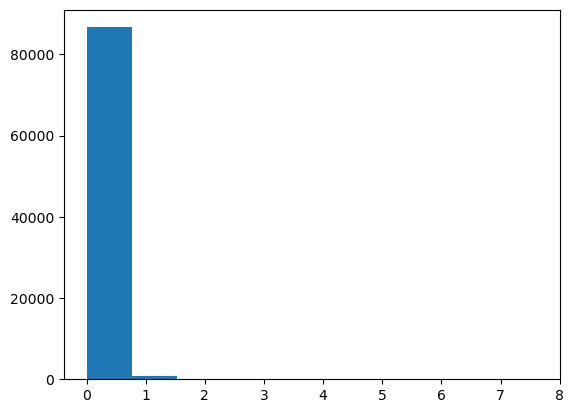

In [24]:
import matplotlib.pyplot as plt
#%matplotlib notebook
plt.hist(nutrient_ratio['Energy'])